# DATASET과 DATALOADER

데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어렵습니다. 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다.
Pytorch는 `torch.utils.data.DataLoader`와 `torch.utils.data.Dataset`의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터넷 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다. `Dataset`은 샘플과 정답(Label)을 저장하고, `DataLoader`는 `Dataset`을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.

Pytorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 다양한 미리 준비해둔 데이터셋을 제공합니다. 데이터셋은 `torch.utils.data.Dataset` 의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있습니다. 이러한 라이브러리는 `torch.utils.data.DataLoader` 와 호환되어 모델 학습을 위한 데이터를 쉽게 사용할 수 있도록 합니다.

## 데이터셋 불러오기

TorchVision에서 *Fashion-MNIST*데이터셋을 불러오는 예제를 살펴보겠습니다. Fashion-MNIST는 Zalando의 기사 이미지 데이터셋입니다. 10개의 카테고리와 70,000개의 흑백 이미지로 구성되어 있습니다. 각 이미지는 해상도 28x28 픽셀로 구성되어 있습니다.

다음 매개변수들을 사용하여 `FashionMNIST` 데이터셋을 불러옵니다:
* `root`는 훈련/테스트 데이터가 저장되는 경로입니다.
* `train`은 훈련용 또는 테스트용 데이터셋 여부를 지정합니다.
* `download=True`는 `root`에 데이터가 없는 경우 인터넷에서 다운로드합니다.
* `transform`과 `target_transform`은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.  

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [8]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 데이터셋을 반복하고 시각화하기

`Dataset`에 리스트(list)처럼 직접 접근(index)할 수 있습니다. 또한 `torchvision` 패키지의 `utils` 함수를 사용하여 가장 처음의 몇 개의 샘플을 시각화(visualize)해볼 수 있습니다.

In [9]:
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

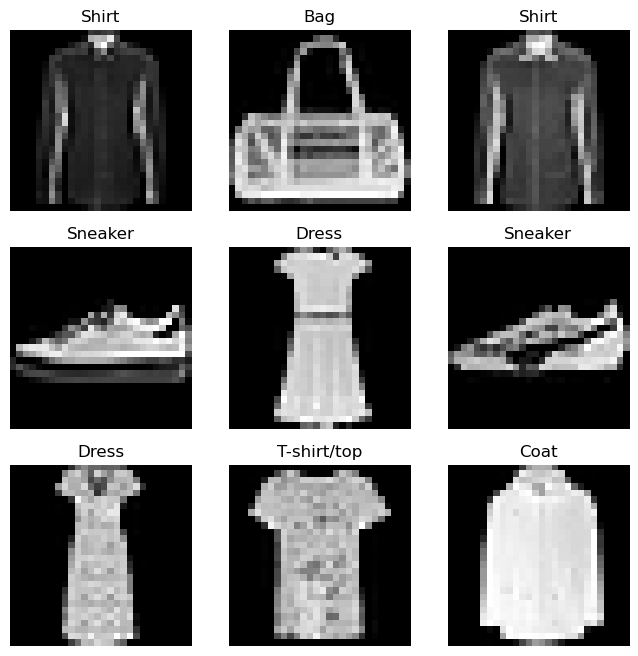

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset클래스는 반드시 3개 함수를 구현해야 합니다. `__init__`, `__len__`, and `__getitem__`. 아래 구현을 살펴보면 Fashion-MNIST 이미지들은 `img_dir`디렉토리에 저장되고, 정답은`annotations_file` CSV 파일에 별도로 저장됩니다.

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataLoader(Dataset):
    """
    `__init__`함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 여기서는 이미지와 주석파일(annotation_file)이 포함된 디렉토리와 두가지 변형(transform)을 초기화합니다.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    """
    `__len__`함수는 데이터셋의 샘플 개수를 반환합니다.
    """        
    def __len__(self):
        return len(self.img_labels)
    
    """
    `__getitem__`함수는 주어진 인덱스 `idx`에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, `read_image`를 사용하여 이미지를 텐서로 변환하고, `self.img_labels`의 csv데이터에서 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.
    """
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## DataLoader로 학습용 데이터 준비하기

`Dataset`은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 "미니배치(minibatch)"로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 `multiprocessing` 을 사용하여 데이터 검색 속도를 높이려고 합니다.

`DataLoader`는 간단한 API로 이러한 복잡한 과정들을 추상화한 반복 가능한 객체(iteratable)입니다.

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 반복하기(iterate)

`DataLoader`에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회(iteration)는 (각각 `batch_size=64`의 특징(feature)과 정답(label)을 포함하는) `train_features`와 `train_labels`의 묶음(batch)을 반환합니다. `shuffle=True`로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다. (데이터셋이 반복되면서) `shuffle=True`로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 0


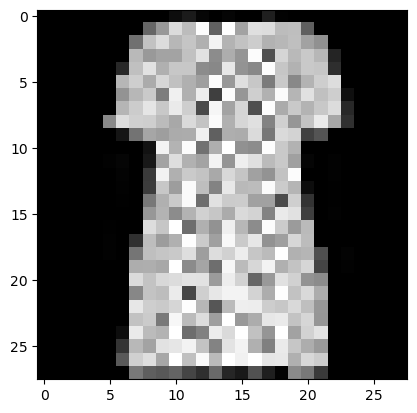

In [7]:
train_future, train_label = next(iter(train_dataloader))
print(f"Feature batch shape: {train_future.size()}")
print(f"Labels batch shape: {train_label.size()}")

img = train_future[0].squeeze()
label = train_label[0]
plt.imshow(img, cmap="gray")
print(f"Label: {label}")
plt.show()